In [1]:
import autograd.numpy as np
import matplotlib.pyplot as plt
import control as ct
from scipy.integrate import solve_ivp
import scipy as sp

from HJK.dynamics.systems import simple2Dsystem
#from HJK.basis.monomials import monomials
from HJK.optimizers.optimizers import cvx
from HJK.eigfun.eigfun import monomial_eigfun, eval_monomial_eigfun
from HJK.controllers.LQR import u_LQR
from HJK.controllers.koopman import u_HJK1

from autograd import jacobian
import math

## Define the system dynamics

### Plot free response of the system

In [2]:
t_span = [0, 10]
x0 = np.array([1, 1])
t = np.linspace(0, 10, 10000)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

params = {"mu":0.5, "lam":-10.0}

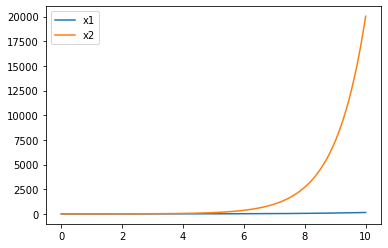

In [3]:
u = 0
sol = solve_ivp(simple2Dsystem, t_span, x0, t_eval=t, args = (u, params))
t = sol.t
y = sol.y

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['x1', 'x2'])
plt.show(block=False)

### Linearize the system

In [4]:
A = np.array([[params.get('mu'), 0],[0, params.get('lam')]])
B = np.array([[1],[1]])

## Collect random datapoints from a domain

In [5]:
domain = 5
dim = 2
numIC = 1000
np.random.seed(1)
X = np.random.uniform(low=-domain, high=domain, size=(dim,numIC)).astype(float) 

## Generate basis functions
Monomials from d3s github

In [6]:
degree = 2
d3s_monomials = monomials(degree)
d3s_monomials.display(np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0]),2)

1.000001 + 1.00000 x_1 + 1.00000 x_2 + 1.00000 x_1^2 + 1.00000 x_1 x_2 + 1.00000 x_2^2


In [7]:
Psi = d3s_monomials(X)
DPsi = d3s_monomials.diff(X)

# remove 1 and linear parts
Psi = Psi[dim+1:,:]
DPsi = DPsi[dim+1:,:]

# get length of Psi to determine coefficient U dimensions
Nbs = np.shape(Psi)[0]

## Setup Optimization problem

### Using CVXpy

In [8]:
U = cvx(simple2Dsystem, params, A, X, Psi , DPsi)

Found a feasible x in R^2 that has 1 nonzeros.
optimal objective value: 4.455324267447211e-12
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [-9.09090909e-01 -3.12765624e-19  2.01586570e-18]]


In [9]:
Phi, DPhi = eval_monomial_eigfun(X, A, U, Psi, DPsi)

# LQR Control

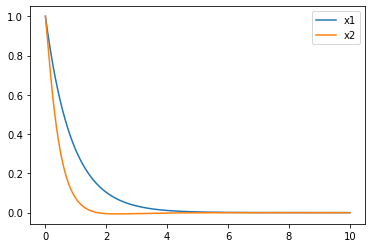

In [10]:
x0 = np.array([1, 1])
Q = np.identity(dim)
R = 1.0
params = {"mu":0.5, "lam":-10.0,"u":"LQR"}
sol = solve_ivp(simple2Dsystem, t_span, x0, t_eval=t, args = (u_LQR, params))
t = sol.t
y = sol.y

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['x1', 'x2'])
plt.show(block=False)

# HJK Procedure 1

c:\Users\Sri\anaconda3\envs\pytorch\lib\site-packages\slycot\synthesis.py:329: ComplexWarning: Casting complex values to real discards the imaginary part
  A_inv, X, rcond, wr, wi, S, U, info = _wrapper.sb02md(


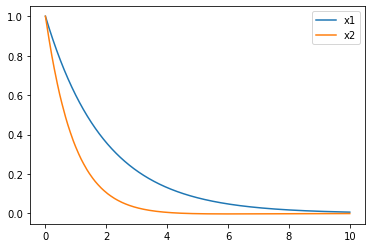

In [11]:
x0 = np.array([1, 1])
params = {"mu":0.5, "lam":-10.0,"u":"HJK1", "U":U, "degree":degree, "Q":Q, "R":R,}
sol = solve_ivp(simple2Dsystem, t_span, x0, t_eval=t, args = (u_HJK1, params))
t = sol.t
y = sol.y

# Plot the response
plt.figure(1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['x1', 'x2'])
plt.show(block=False)

# HJK Procedure 2

In [43]:
def eigfun(x):
    # To evaluate eigenfunctions at each points x in R^n
    x = np.array([x]).T # add extra dimension for matmul
    dim = np.shape(x)[0]
    monomial_basis = monomials(degree, x)
    Psi = monomial_basis(x)
    DPsi = monomial_basis.diff(x)
    # remove 1 and linear parts
    Psi = Psi[dim+1:,:]
    DPsi = DPsi[dim+1:,:]

    W = sp.linalg.eig(A, left=True, right=False)[1]
    Phi = W.T @ x + W.T @ (U @ Psi)
    DPhi = []
    numIC = np.shape(x)[1]
    for i in range(numIC):
        DPhi.append(W.T + W.T @ U @ DPsi[:,:,i])
    DPhi = np.reshape(DPhi, (np.shape(x)[0],-1))

    return Phi


In [2]:
def monomials(x):
    p = 2
    '''
    Evaluate all monomials of order up to p for all data points in x.
    '''
    [d, m] = x.shape # d = dimension of state space, m = number of test points
    c = allMonomialPowers(d, p) # matrix containing all powers for the monomials
    n = c.shape[1] # number of monomials
    y = np.ones([n, m])
    for i in range(n):
        for j in range(d):
            y[i, :] = y[i, :] * np.power(x[j, :], c[j, i])
    return y

def allMonomialPowers(d, p):
    '''
    All monomials in d dimensions of order up to p.
    '''
    # Example: For d = 3 and p = 2, we obtain
    # [[ 0  1  0  0  2  1  1  0  0  0]
    #  [ 0  0  1  0  0  1  0  2  1  0]
    #  [ 0  0  0  1  0  0  1  0  1  2]]
    n = nchoosek(p + d, p) # number of monomials
    x = np.zeros(d) # vector containing powers for the monomials, initially zero
    c = np.zeros([d, n]) # matrix containing all powers for the monomials
    for i in range(1, n):
        c[:, i] = nextMonomialPowers(x)
    c = np.flipud(c) # flip array in the up/down direction
    return c

def nchoosek(n, k):
    '''
    Computes binomial coefficients.
    '''
    return math.factorial(n)//math.factorial(k)//math.factorial(n-k) # integer division operator


def nextMonomialPowers(x):
    '''
    Returns powers for the next monomial. Implementation based on John Burkardt's MONOMIAL toolbox, see
    http://people.sc.fsu.edu/~jburkardt/m_src/monomial/monomial.html.
    '''
    m = len(x)
    j = 0
    for i in range(1, m): # find the first index j > 1 s.t. x[j] > 0
        if x[i] > 0:
            j = i
            break
    if j == 0:
        t = x[0]
        x[0] = 0
        x[m - 1] = t + 1
    elif j < m - 1:
        x[j] = x[j] - 1
        t = x[0] + 1
        x[0] = 0
        x[j-1] = x[j-1] + t
    elif j == m - 1:
        t = x[0]
        x[0] = 0
        x[j - 1] = t + 1
        x[j] = x[j] - 1
    return x

In [44]:
def numerical_jacobian(f, A, U, degree, xs, dx=1e-8):
  """
      f is a function that accepts input of shape (n_points, input_dim)
      and outputs (n_points, output_dim)

      return the jacobian as (n_points, output_dim, input_dim)
  """
  ys = f(xs, A, U, degree)
  print(np.shape(ys))
  x_dim = xs.shape[0]
  print(x_dim)
  y_dim = ys.shape[0]
  print(x_dim)
  
  jac = np.empty((y_dim, x_dim, xs.shape[1]))
  print(np.shape(jac))

  for i in range(x_dim):
    x_try = xs + dx * e(x_dim, i + 1)
    jac[:, :, i] = (f(x_try, A, U, degree) - ys) / dx
  
  return jac

def e(n, i):
  ret = np.zeros(n)
  ret[i - 1] = 1.0
  return ret

In [55]:
import autograd.numpy as np
from autograd import grad, jacobian

x = np.array([1,2], dtype=float)

def cost(x):
    val = 0  
    return forloopfun(val, x)

def forloopfun(val,x ):
    for i in range(10):
        val += i*x[0] + i*x[1]**2
    return val


jacobian_cost = jacobian(cost)

jacobian_cost(x)

array([ 45., 180.])

In [52]:
x = np.array([[1, 2]], dtype=float)
x=x.T
Psi = monomials(x)
DPsi = jacobian(monomials)
DPsi(x)

ValueError: setting an array element with a sequence.